In [466]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [467]:
data = pd.read_csv('https://raw.githubusercontent.com/fachrygunawan/TA_dataset_padang/main/test.csv')
data

,Tanggal,Positif,Sembuh,Kematian
0,16-Mar-20,0,0,0
1,17-Mar-20,0,0,0
2,18-Mar-20,0,0,0
3,19-Mar-20,0,0,0
4,20-Mar-20,0,0,0
...,...,...,...,...
689,6-Feb-22,42538,41746,554
690,7-Feb-22,42551,41753,554
691,8-Feb-22,42649,41779,554
692,9-Feb-22,42794,41799,555


In [468]:
# #set tanggal ke 1 jul 21
# df['Tanggal'] = pd.to_datetime(df['Tanggal'])
# start_date = "1-Jan-22"
# end_date = df['Tanggal'].max()
# df = df.query(f'Tanggal >= "{start_date}" and Tanggal <= "{end_date}"')
# df.head()

In [469]:
n =  919145
I0 = 42242
R0 = 41687
S0 = n - I0 - R0

In [470]:
df['Suspek'] = n - df['Positif'] - df['Sembuh']
df.head()

,Tanggal,Positif,Sembuh,Suspek
0,2021-09-01,41141,39361,838643
1,2021-09-02,41209,39527,838409
2,2021-09-03,41284,39704,838157
3,2021-09-04,41356,39912,837877
4,2021-09-05,41402,40074,837669


In [471]:
import numpy as np

# Total populasi Kota Padang
N = 919145

# Menemukan indeks untuk tanggal 1 Juli 2021 dalam data
start_date = '1-Jul-21'
start_index = data[data['Tanggal'] == start_date].index[0]

# Mengatur nilai awal untuk S, I, R
I0 = data.at[start_index, 'Positif'] - data.at[start_index, 'Sembuh'] - data.at[start_index, 'Kematian']
R0 = data.at[start_index, 'Sembuh'] + data.at[start_index, 'Kematian']
S0 = N - I0 - R0

# Asumsi nilai beta dan gamma
beta = 0.3
gamma = 0.1

# Menyiapkan array untuk menyimpan nilai S, I, R
S = np.zeros(len(data) - start_index)
I = np.zeros(len(data) - start_index)
R = np.zeros(len(data) - start_index)

S[0], I[0], R[0] = S0, I0, R0

# Mengembalikan nilai awal dan indeks awal
S0, I0, R0, start_index


(896092, 1122, 21931, 470)

In [472]:
def rk4(y, f, t, h):
    """
    Implementasi metode Runge-Kutta orde 4.

    :param y: Nilai awal variabel.
    :param f: Fungsi yang mendefinisikan persamaan diferensial.
    :param t: Waktu awal.
    :param h: Langkah waktu.
    :return: Nilai variabel pada waktu berikutnya.
    """
    k1 = h * f(y, t)
    k2 = h * f(y + 0.5 * k1, t + 0.5 * h)
    k3 = h * f(y + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(y + k3, t + h)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def sir_model(y, t):
    """
    Model SIR.

    :param y: Array [S, I, R].
    :param t: Waktu (tidak digunakan dalam model ini).
    :return: Array [dS/dt, dI/dt, dR/dt].
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return np.array([dSdt, dIdt, dRdt])

# Langkah waktu (1 hari)
h = 1

# Mengiterasi dengan metode RK4
for i in range(1, len(S)):
    t = i - 1
    S[i], I[i], R[i] = rk4(np.array([S[i-1], I[i-1], R[i-1]]), sir_model, t, h)

# Menampilkan beberapa nilai S, I, dan R sebagai sampel
S[:5], I[:5], R[:5]


(array([896092.        , 895730.21747093, 895291.89788218, 894760.9761009 ,
        894118.07420943]),
 array([1122.        , 1360.06094499, 1648.41801099, 1997.59687298,
        2420.27886781]),
 array([21931.        , 22054.72158408, 22204.68410683, 22386.42702612,
        22606.64692277]))

In [473]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def sir_model_opt(y, t, beta, gamma):
    """
    Model SIR dengan beta dan gamma sebagai parameter.
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return np.array([dSdt, dIdt, dRdt])

def integrate_sir_model(beta_gamma):
    """
    Mengintegrasikan model SIR dengan nilai beta dan gamma tertentu.
    """
    beta, gamma = beta_gamma
    S = np.zeros(len(data) - start_index)
    I = np.zeros(len(data) - start_index)
    R = np.zeros(len(data) - start_index)
    S[0], I[0], R[0] = S0, I0, R0

    for i in range(1, len(S)):
        t = i - 1
        S[i], I[i], R[i] = rk4(np.array([S[i-1], I[i-1], R[i-1]]), lambda y, t: sir_model_opt(y, t, beta, gamma), t, h)

    return I

def rmse(beta_gamma):
    """
    Menghitung RMSE antara data Infected yang diamati dan yang diprediksi oleh model.
    """
    I_pred = integrate_sir_model(beta_gamma)
    I_obs = data['Positif'][start_index:] - data['Sembuh'][start_index:] - data['Kematian'][start_index:]
    return mean_squared_error(I_obs, I_pred, squared=False)

# Mencari nilai beta dan gamma yang meminimalkan RMSE
initial_guess = [0.3, 0.1]
optimization_result = minimize(rmse, initial_guess, method='L-BFGS-B', bounds=[(0, 1), (0, 1)])

# Nilai beta dan gamma terbaik dan RMSE yang terkait
best_beta, best_gamma = optimization_result.x
best_rmse = rmse(optimization_result.x)

best_beta, best_gamma, best_rmse

(0.9065892600311285, 0.8036917596516601, 93.15579906730032)

In [474]:
# Modifikasi fungsi sir_model untuk menerima beta dan gamma sebagai parameter
def modified_sir_model(y, t, beta, gamma):
    """
    Model SIR yang dimodifikasi untuk menerima beta dan gamma.

    :param y: Array [S, I, R].
    :param t: Waktu (tidak digunakan dalam model ini).
    :param beta: Tingkat transmisi penyakit.
    :param gamma: Tingkat pemulihan penyakit.
    :return: Array [dS/dt, dI/dt, dR/dt].
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return np.array([dSdt, dIdt, dRdt])

# Mengiterasi dengan metode RK4 menggunakan beta dan gamma terbaik
S = np.zeros(len(data) - start_index)
I = np.zeros(len(data) - start_index)
R = np.zeros(len(data) - start_index)
S[0], I[0], R[0] = S0, I0, R0

for i in range(1, len(S)):
    t = i - 1
    S[i], I[i], R[i] = rk4(np.array([S[i-1], I[i-1], R[i-1]]), lambda y, t: modified_sir_model(y, t, best_beta, best_gamma), t, h)

# Menampilkan beberapa nilai S, I, dan R sebagai sampel setelah menggunakan nilai beta dan gamma terbaik
S[:5], I[:5], R[:5]


(array([896092.        , 895060.25878911, 893944.89979371, 892740.59106443,
        891441.91939158]),
 array([1122.        , 1215.03153273, 1314.38490323, 1420.2373827 ,
        1532.72210702]),
 array([21931.        , 22869.70967816, 23885.71530306, 24984.17155286,
        26170.3585014 ]))

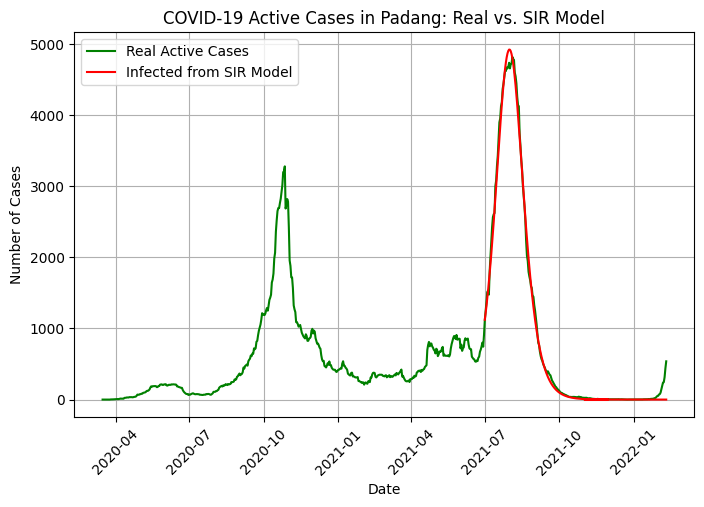

In [475]:
# Membuat DataFrame sir_data
sir_data = pd.DataFrame({
    'Tanggal': pd.to_datetime(data['Tanggal'][start_index:]).reset_index(drop=True),
    'Susceptible': S,
    'Infected': I,
    'Removed': R
})

# Membuat plot
plt.figure(figsize=(8, 5))
plt.plot(pd.to_datetime(data['Tanggal']), data['Positif'] - data['Sembuh'] - data['Kematian'], color='g', label='Real Active Cases')
plt.plot(sir_data['Tanggal'], sir_data['Infected'], 'r', label='Infected from SIR Model')
plt.grid()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("COVID-19 Active Cases in Padang: Real vs. SIR Model")
plt.xticks(rotation=45)
plt.show()


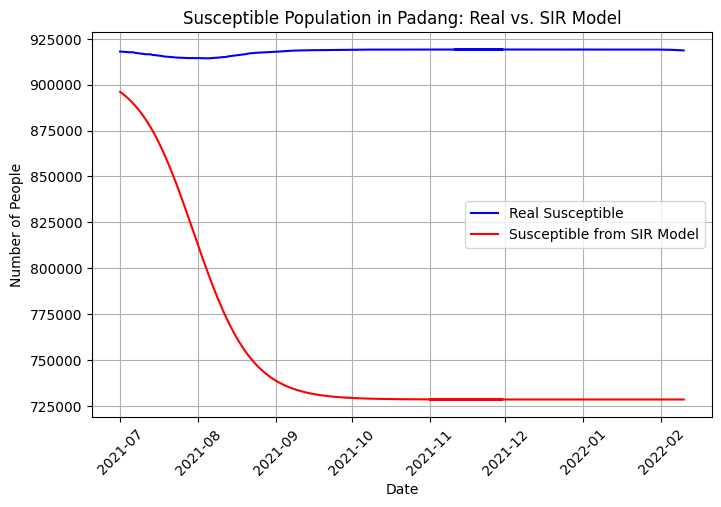

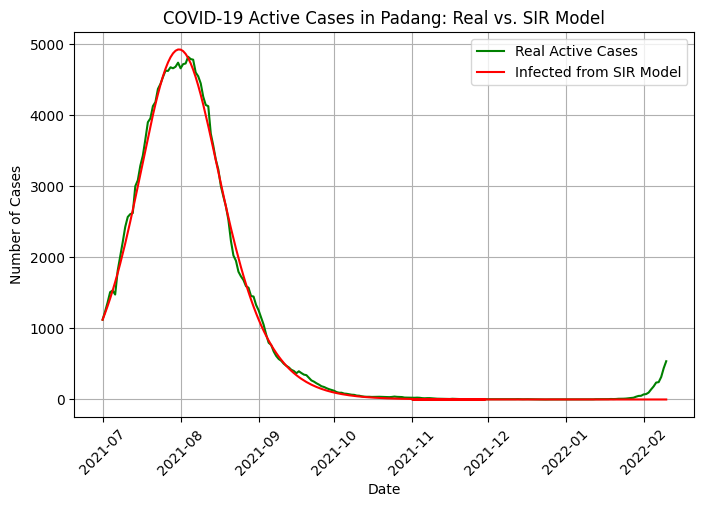

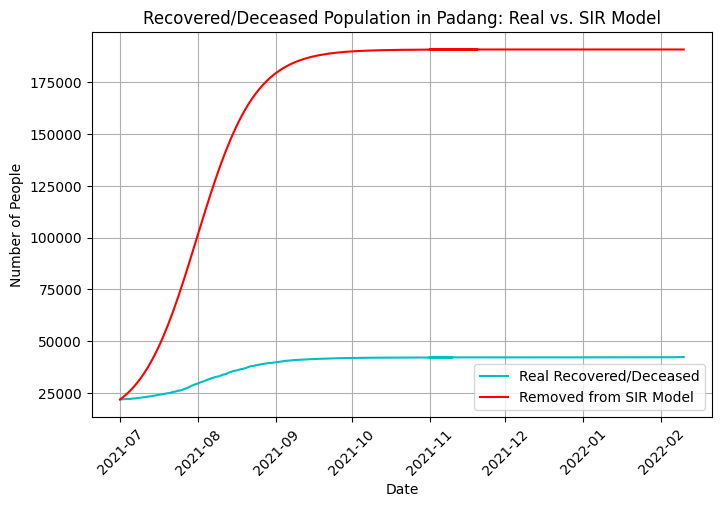

In [476]:
# Memastikan data tanggal dan data kasus memiliki panjang yang sama
# Data asli dimulai dari tanggal 1 Juli 2021
data_from_start_date = data[start_index:].reset_index(drop=True)

# Susceptible Comparison
plt.figure(figsize=(8, 5))
plt.plot(pd.to_datetime(data_from_start_date['Tanggal']), N - (data_from_start_date['Positif'] - data_from_start_date['Sembuh'] - data_from_start_date['Kematian']), color='b', label='Real Susceptible')
plt.plot(sir_data['Tanggal'], sir_data['Susceptible'], 'r', label='Susceptible from SIR Model')
plt.grid()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of People")
plt.title("Susceptible Population in Padang: Real vs. SIR Model")
plt.xticks(rotation=45)
plt.show()

# Infected Comparison
plt.figure(figsize=(8, 5))
plt.plot(pd.to_datetime(data_from_start_date['Tanggal']), data_from_start_date['Positif'] - data_from_start_date['Sembuh'] - data_from_start_date['Kematian'], color='g', label='Real Active Cases')
plt.plot(sir_data['Tanggal'], sir_data['Infected'], 'r', label='Infected from SIR Model')
plt.grid()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("COVID-19 Active Cases in Padang: Real vs. SIR Model")
plt.xticks(rotation=45)
plt.show()

# Removed Comparison
plt.figure(figsize=(8, 5))
plt.plot(pd.to_datetime(data_from_start_date['Tanggal']), data_from_start_date['Sembuh'] + data_from_start_date['Kematian'], color='c', label='Real Recovered/Deceased')
plt.plot(sir_data['Tanggal'], sir_data['Removed'], 'r', label='Removed from SIR Model')
plt.grid()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of People")
plt.title("Recovered/Deceased Population in Padang: Real vs. SIR Model")
plt.xticks(rotation=45)
plt.show()
